In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
# Load Wine Quality dataset
red_wine_df = pd.read_csv("./data/winequality-red.csv", sep=';')
white_wine_df = pd.read_csv("./data/winequality-white.csv", sep=';')

# Add a column to differentiate between red and white wine, then combine
red_wine_df['wine_type'] = 'red'
white_wine_df['wine_type'] = 'white'
df = pd.concat([red_wine_df, white_wine_df], axis=0)

# Drop any rows with missing values and ensure the target is of type float
df = df.dropna(); df['quality'] = pd.to_numeric(df['quality'], errors='coerce').astype(float) # Assuming the 12th column is the target

# Define features and target
X = df.iloc[:, :11].values  # Features (first 11 columns)
y = df.iloc[:, 11].values   # Target (12th column: wine quality)
wine_type = df.iloc[:, 12]  # Categorical variable (wine_type)

# Scale the dataset and split into training and test sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test, wine_train, wine_test = train_test_split(X_scaled, y, wine_type, test_size=0.5, random_state=42, stratify=wine_type)

# Define the proportions for each class in the training set
unbalance_factors = [0.1, 1]
category_proportion_mapping = {'white': unbalance_factors[0], 'red': unbalance_factors[1]}

subset_list = []
for category, proportion in category_proportion_mapping.items():
    # Get all rows for the current category
    category_mask = wine_train == category
    category_X = X_train[category_mask]
    category_y = y_train[category_mask]
    category_wine = wine_train[category_mask]
    num_elements = int(len(category_X) * proportion)
    subset_X = category_X[:num_elements]
    subset_y = category_y[:num_elements]
    subset_wine = category_wine[:num_elements]
    subset_list.append((subset_X, subset_y, subset_wine))

# Combine the subsets for the specified categories
X_train = np.vstack([subset[0] for subset in subset_list])
y_train = np.hstack([subset[1] for subset in subset_list])
wine_train = np.hstack([subset[2] for subset in subset_list])

# Create separate datasets based on unique values in 'ocean_proximity'
unique_categories = list(set(wine_train))
tensor_datasets = []; sizes = []
for category in unique_categories:
    # Filter the training data based on the current category of wine_type
    mask_train = wine_train == category
    X_train_subset = X_train[mask_train]
    y_train_subset = y_train[mask_train]
    sizes.append(len(X_train_subset))
    
    # Convert to PyTorch tensors
    tensor_data = torch.tensor(X_train_subset, dtype=torch.float32)
    tensor_labels = torch.tensor(y_train_subset, dtype=torch.float32).view(-1, 1)
    
    # Create TensorDataset and append to list
    tensor_datasets.append(TensorDataset(tensor_data, tensor_labels))

batch_size = 100
k = len(sizes) # Number of datasets to mix

# Convert train datasets to PyTorch tensors and create DataLoader
train_tensor_data = torch.tensor(X_train, dtype=torch.float32)
train_tensor_labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(train_tensor_data, train_tensor_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Convert test datasets to PyTorch tensors and create DataLoader
test_tensor_data = torch.tensor(X_test, dtype=torch.float32)
test_tensor_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
test_dataset = TensorDataset(test_tensor_data, test_tensor_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def shuffle_class_data(tensor_datasets):
    shuffled_indices = []
    for dataset in tensor_datasets:
        num_samples = dataset.tensors[0].size(0)
        # Shuffle indices for the current class
        shuffled_indices.append(torch.randperm(num_samples))
    return shuffled_indices


Number of samples per class after applying unbalance factors:
White Wine: 244 samples
Red Wine: 799 samples

Total number of samples in the imbalanced training dataset: 1043


In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(11, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [4]:
criterion = nn.MSELoss()
N_total = sum(sizes)

# Initialize mixing parameters alpha
epochs = 300
iterations = 5
M = int(np.floor(N_total / batch_size)) # Number of training batches
train_errors = np.zeros((epochs, iterations))
classical_errors = np.zeros((epochs, iterations))
test_errors = np.zeros((epochs, iterations))
classical_test_errors = np.zeros((epochs, iterations))

for iters in range(iterations):
    # Initialize the model, criterion, and optimizer
    model = SimpleNN()
    model_l2m = SimpleNN()
    model.load_state_dict(model_l2m.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    optimizer_l2m = optim.Adam(model_l2m.parameters(), lr=1e-4)
    alpha = torch.tensor([N_i / N_total for N_i in sizes], dtype=torch.float32)
    classical_alpha = torch.tensor([N_i / N_total for N_i in sizes], dtype=torch.float32)
    alpha_lr = 5e-2

    # Training loop
    for epoch in range(epochs):
        l2m_loss = 0; classical_loss = 0; total = 0; l2m_test_loss = 0; classical_test_loss = 0; total_test = 0;
        prev_indices = np.zeros(k, dtype=int)
        tracking_error = np.zeros(k, dtype=float)
        shuffled_indices = shuffle_class_data(tensor_datasets)
        
        # Learn2Mix Training
        model_l2m.train()
        for j in range(M):  # For each batch in an epoch
            combined_data = []; combined_labels = []
            for i in range(k):  # For each dataset
                num_samples = max(int(alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                data_list = []; labels_list = []; remaining = num_samples
                while remaining > 0:
                    available = len(tensor_datasets[i]) - prev_indices[i]
                    take = min(available, remaining)
                    indices = shuffled_indices[i][prev_indices[i]:prev_indices[i] + take]
                    data_list.append(tensor_datasets[i].tensors[0][indices])
                    labels_list.append(tensor_datasets[i].tensors[1][indices])
                    
                    # Update the remaining samples and the previous index, and wrap around if the end of the dataset is reached
                    remaining -= take; prev_indices[i] += take
                    if prev_indices[i] >= len(tensor_datasets[i]): prev_indices[i] = 0  # Reset to start
                
                # Concatenate all collected data and labels
                combined_data.append(torch.cat(data_list, dim=0))
                combined_labels.append(torch.cat(labels_list, dim=0))
                
            # Inner optimization step: update model parameters
            optimizer_l2m.zero_grad()
            x_mixed = torch.cat(combined_data, dim=0)
            y_mixed = torch.cat(combined_labels, dim=0)
            z_mixed = model_l2m(x_mixed)
            loss = criterion(z_mixed, y_mixed)
            loss.backward()
            optimizer_l2m.step()

            # Compute class-wise losses
            start_idx = 0
            for i in range(k):
                num_samples = max(int(alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                tracking_error[i] = criterion(z_mixed[start_idx:start_idx + num_samples], y_mixed[start_idx:start_idx + num_samples])
                start_idx += num_samples
            
        # Outer optimization step: update alpha based on dataset-specific gradients
        rewards = tracking_error / np.sum(tracking_error)
        alpha += alpha_lr * (torch.tensor(rewards) - alpha)
        
        # Fixed weights training
        model.train()
        for j in range(M): # For each batch in an epoch
            combined_data = []; combined_labels = []
            for i in range(k):  # For each dataset
                num_samples = max(int(classical_alpha[i].item() * batch_size), 0)  # Number of samples from dataset 'i'
                data_list = []; labels_list = []; remaining = num_samples
                while remaining > 0:
                    available = len(tensor_datasets[i]) - prev_indices[i]
                    take = min(available, remaining)
                    indices = shuffled_indices[i][prev_indices[i]:prev_indices[i] + take]
                    data_list.append(tensor_datasets[i].tensors[0][indices])
                    labels_list.append(tensor_datasets[i].tensors[1][indices])
                    
                    # Update the remaining samples and the previous index, and wrap around if the end of the dataset is reached
                    remaining -= take; prev_indices[i] += take
                    if prev_indices[i] >= len(tensor_datasets[i]): prev_indices[i] = 0  # Reset to start
                
                # Concatenate all collected data and labels
                combined_data.append(torch.cat(data_list, dim=0))
                combined_labels.append(torch.cat(labels_list, dim=0))

            optimizer.zero_grad()
            x_mixed = torch.cat(combined_data, dim=0)
            y_mixed = torch.cat(combined_labels, dim=0)
            z_mixed = model(x_mixed)
            loss = criterion(z_mixed, y_mixed)
            loss.backward()
            optimizer.step()

        # # Classical NN Training
        # model.train()
        # for X_train, y_train in train_loader:
        #     optimizer.zero_grad()
        #     classical_outputs = model(X_train)
        #     loss = criterion(classical_outputs, y_train)
        #     loss.backward()
        #     optimizer.step()
            
        # Computing Train Error
        model.eval(); model_l2m.eval()
        with torch.no_grad():
            for X_train, y_train in train_loader:
                train_outputs = model_l2m(X_train)
                classical_outputs = model(X_train)
                
                total += X_train.size(0)
                l2m_loss += F.mse_loss(train_outputs, y_train, reduction='sum').item()
                classical_loss += F.mse_loss(classical_outputs, y_train, reduction='sum').item()

        # Computing Test Error
        model.eval(); model_l2m.eval()
        with torch.no_grad():
            for X_test, y_test in test_loader:
                test_outputs = model_l2m(X_test)
                classical_outputs = model(X_test)
                
                total_test += X_test.size(0)
                l2m_test_loss += F.mse_loss(test_outputs, y_test, reduction='sum').item()
                classical_test_loss += F.mse_loss(classical_outputs, y_test, reduction='sum').item()

        train_errors[epoch, iters] = l2m_loss / total
        classical_errors[epoch, iters] = classical_loss / total
        test_errors[epoch, iters] = l2m_test_loss / total_test
        classical_test_errors[epoch, iters] = classical_test_loss / total_test

        if epoch % 50 == 0:
            print(f"Iteration {iters}, Epoch {epoch}, Cls Error: {classical_test_errors[epoch, iters]:.4f}, L2M Error: {test_errors[epoch, iters]:.4f}, Alpha: {np.round(alpha.detach().numpy(),4)}")

Iteration 0, Epoch 0, Cls Error: 31.6354, L2M Error: 31.6353, Alpha: [0.2491 0.7509]
Iteration 0, Epoch 50, Cls Error: 21.8284, L2M Error: 20.6898, Alpha: [0.629 0.371]
Iteration 0, Epoch 100, Cls Error: 15.4430, L2M Error: 10.3311, Alpha: [0.7348 0.2652]
Iteration 0, Epoch 150, Cls Error: 9.5046, L2M Error: 3.9075, Alpha: [0.6981 0.3019]
Iteration 0, Epoch 200, Cls Error: 4.7403, L2M Error: 2.1913, Alpha: [0.5774 0.4226]
Iteration 0, Epoch 250, Cls Error: 2.4843, L2M Error: 1.7714, Alpha: [0.5324 0.4676]
Iteration 1, Epoch 0, Cls Error: 32.2180, L2M Error: 32.2189, Alpha: [0.2494 0.7506]
Iteration 1, Epoch 50, Cls Error: 22.0722, L2M Error: 21.0606, Alpha: [0.5888 0.4112]
Iteration 1, Epoch 100, Cls Error: 15.3689, L2M Error: 10.3751, Alpha: [0.7041 0.2959]
Iteration 1, Epoch 150, Cls Error: 9.6580, L2M Error: 4.1210, Alpha: [0.6806 0.3194]
Iteration 1, Epoch 200, Cls Error: 4.9680, L2M Error: 2.4367, Alpha: [0.5919 0.4081]
Iteration 1, Epoch 250, Cls Error: 2.6721, L2M Error: 1.9670,

Mean DNN:       1.9912, STDEV DNN:      0.1577
Mean L2M:       1.7798, STDEV L2M:      0.1151


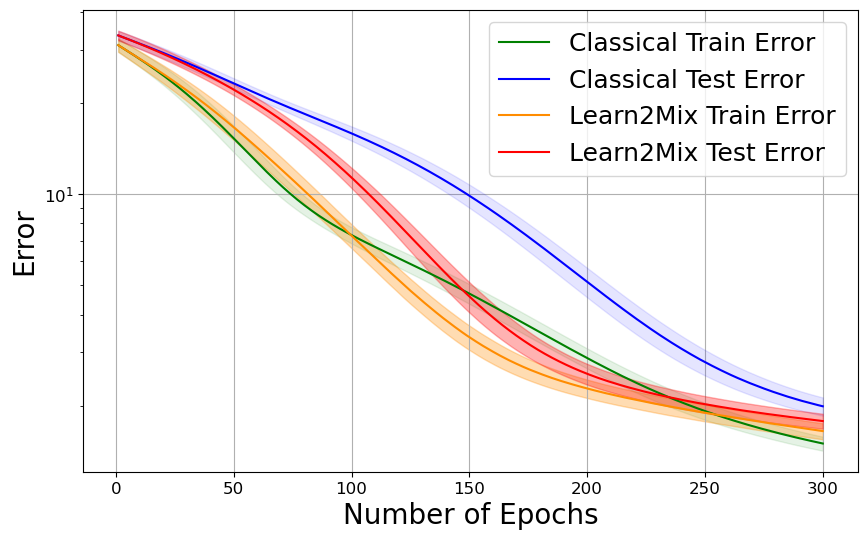

In [5]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    stdev = np.std(data, axis=0)
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci, stdev

A = classical_errors.T[:,:]; B = train_errors.T[:,:]
mean_A, ci_A, stdev_A = compute_mean_and_CI(A)
mean_B, ci_B, stdev_B = compute_mean_and_CI(B)

X = classical_test_errors.T[:,:]; Z = test_errors.T[:,:]
mean_X, ci_X, stdev_X = compute_mean_and_CI(X)
mean_Z, ci_Z, stdev_Z = compute_mean_and_CI(Z)

print(f'Mean DNN:       {mean_X[len(mean_X)-1].round(4)}, STDEV DNN:      {stdev_X[len(stdev_X)-1].round(4)}')
print(f'Mean L2M:       {mean_Z[len(mean_Z)-1].round(4)}, STDEV L2M:      {stdev_Z[len(stdev_Z)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for A
plt.fill_between(epochs_all, mean_A - ci_A, mean_A + ci_A, color='green', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_A, 'g-', label="Classical Train Error", zorder=20)

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=10)
plt.plot(epochs_all, mean_X, 'b-', label="Classical Test Error", zorder=30)

# Plotting for B
plt.fill_between(epochs_all, mean_B - ci_B, mean_B + ci_B, color='darkorange', alpha=0.3, zorder=0)
plt.plot(epochs_all, mean_B, '-', color='darkorange', label="Learn2Mix Train Error", zorder=20)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='red', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, 'r-', label="Learn2Mix Test Error", zorder=30)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Error", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 18},loc='upper right')
plt.grid(True)
plt.savefig('test.png', bbox_inches='tight')